In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyproj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.8 MB/s eta 0:00:00


In [3]:
import requests as rq
import pandas as pd

shootings_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=73c7e069-701f-4910-986d-b950f46c91a1&limit=10000"
shootings = pd.DataFrame((rq.get(url = shootings_URL)).json().get('result').get('records'))

In [4]:
crime_incidents_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=b973d8cb-eeb2-4e7e-99da-c92938efc9c0&limit=5000000000"
crime_incidents = pd.DataFrame((rq.get(url = crime_incidents_URL)).json().get('result').get('records'))

In [5]:
city_council_URL = "https://data.boston.gov/api/3/action/datastore_search?resource_id=7918a624-2c23-493a-8d13-1c8fbd085e2d&limit=5000000000"
city_councils = pd.DataFrame((rq.get(url = city_council_URL)).json().get('result').get('records'))

In [6]:
common_ids = set(shootings['_id']).intersection(set(crime_incidents['_id']))

In [7]:
shootings = pd.merge(shootings, crime_incidents[['Long', 'Lat', '_id']], on='_id', how='inner')

In [8]:
selected_districts = ['D4', 'C11', 'B3', 'B2', 'E5']
shootings = shootings[shootings['district'].isin(selected_districts)]

In [ ]:
shootings.head(5)

,shooting_type_v2,victim_ethnicity_NIBRS,district,incident_num,victim_race,multi_victim,victim_gender,_id,shooting_date,Long,Lat
0,Non-Fatal,Not Hispanic or Latinx,C11,I152000196-00,Black or African American,f,Male,1,2015-01-01 13:30:00+00,-71.12883623098992,42.28630091783755
2,Non-Fatal,Not Hispanic or Latinx,E5,I152001014-00,Black or African American,f,Male,3,2015-01-04 18:52:00+00,-71.14822128377165,42.28709355259107
3,Non-Fatal,Not Hispanic or Latinx,B2,I152002232-00,Black or African American,t,Male,4,2015-01-08 22:45:00+00,None,None
4,Non-Fatal,Not Hispanic or Latinx,B2,I152002233-00,Black or African American,t,Female,5,2015-01-08 22:45:00+00,-71.05970910242573,42.29755532959655
5,Non-Fatal,Not Hispanic or Latinx,B2,I152002234-00,Black or African American,t,Male,6,2015-01-08 22:45:00+00,None,None


## Community Center

In [9]:
import pandas as pd

community_centers = pd.read_csv('/content/drive/MyDrive/Team 3/Deliverables/Proposal Deliverables/data/community_centers/community_centers_city_council.csv')

In [10]:
from pyproj import Transformer

def point_to_coords(point_str):
    point_str = point_str.replace('POINT (', '').replace(')', '')
    x, y = point_str.split()
    transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
    lon, lat = transformer.transform(x, y)
    return lon, lat

community_centers[['long', 'lat']] = community_centers['geometry'].apply(lambda x: pd.Series(point_to_coords(x)))

print(community_centers.keys())

Index(['FID', 'OBJECTID', 'SITE', 'PHONE', 'FAX', 'STREET', 'NEIGH', 'ZIP',
       'geometry', 'city_council_id', 'long', 'lat'],
      dtype='object')


In [11]:
shootings.dropna(inplace=True)
community_centers.dropna(inplace=True)

shootings['Lat'] = shootings['Lat'].apply(float)
shootings['Long'] = shootings['Long'].apply(float)

In [ ]:
shootings.shape

(1312, 11)

In [12]:
from geopy import distance

black = 'Black or African American'
white = 'White'
asian = 'Asian'
unknown = 'Unknown'
male = 'Male'
female = 'Female'

def count_shootings_within_radius(center_lat, center_lon, radius, shootings):
    center = (center_lat, center_lon)
    count = 0
    num_black_victims = 0
    num_white_victims = 0
    num_asian_victms = 0
    num_unknown_victims = 0
    num_male_victims = 0
    num_female_victms = 0
    for _, shooting in shootings.iterrows():
        if shooting['considered']:
            continue
        lat, lon = shooting['Lat'], shooting['Long']
        dist = distance.distance(center, (lon, lat)).miles
        if dist <= radius:
            count += 1
            if shootings.at[shooting.name, 'victim_race'] == black:
              num_black_victims += 1
            elif shootings.at[shooting.name, 'victim_race'] == white:
              num_white_victims += 1
            elif shootings.at[shooting.name, 'victim_race'] == asian:
              num_asian_victms += 1
            elif shootings.at[shooting.name, 'victim_race'] == unknown:
              num_unknown_victims += 1

            if shootings.at[shooting.name, 'victim_gender'] == male:
              num_male_victims += 1
            elif shootings.at[shooting.name, 'victim_gender'] == female:
              num_female_victms += 1

            shootings.at[shooting.name, 'considered'] = True
    return pd.Series([count, num_black_victims, num_white_victims, num_asian_victms, num_unknown_victims, num_male_victims, num_female_victms])

radius = 1

shootings['considered'] = False
columns = ['num_shootings_within_radius', 'num_black_victims', 'num_white_victims', 'num_asian_victims', 'num_unknown_victims', 'num_male_victims', 'num_female_victims']
community_centers[columns] = community_centers.apply(lambda row: count_shootings_within_radius(row['lat'], row['long'], radius, shootings), axis=1)

In [13]:
top_centers = community_centers.sort_values(by='num_shootings_within_radius', ascending=False).head(10).reset_index()

top_centers

,index,FID,OBJECTID,SITE,PHONE,FAX,STREET,NEIGH,ZIP,geometry,city_council_id,long,lat,num_shootings_within_radius,num_black_victims,num_white_victims,num_asian_victims,num_unknown_victims,num_male_victims,num_female_victims
0,10,11,0.0,Vine Street,635-1285,635-1291,339 Dudley Street,Roxbury,2119.0,POINT (-7912223.69585512 5210056.16249864),7,42.326782,-71.076715,242,204,30,0,8,218,24
1,3,4,0.0,Golden Age Center,635-5175,635-5647,382 Main St.,Charlestown,2129.0,POINT (-7911466.95047821 5218037.85373099),1,42.379769,-71.069917,194,161,27,0,6,173,21
2,6,7,0.0,Quincy*,635-5129,635-5132,885 Washington St,Boston,2111.0,POINT (-7910915.35743103 5213243.90221071),2,42.347949,-71.064962,128,110,14,2,2,108,20
3,30,31,0.0,Jackson/Mann,635-5153,635-5275,500 Cambridge St.,Allston,2134.0,POINT (-7918990.36211811 5213991.00389212),9,42.352909,-71.137501,98,75,16,0,7,89,9
4,16,17,0.0,Holland*,635-5144,635-5152,85 Olney St.,Dorchester,2121.0,POINT (-7911879.08957177 5206948.65505094),4,42.306140,-71.073619,82,75,6,0,1,72,10
5,22,23,0.0,Hyde Park,635-5178,635-5290,1179 River St.,Hyde Park,2136.0,POINT (-7917152.63992229 5199468.43085871),5,42.256425,-71.120992,82,63,10,0,9,77,5
6,12,13,0.0,Rec. Division @ Madison Park*,635-5206,635-5078,55 Malcom X Blvd,Roxbury,2119.0,POINT (-7913616.64722016 5210794.62348973),7,42.331686,-71.089228,81,67,13,0,1,73,8
7,1,2,0.0,Paris Street Pool*,635-1410,635-5079,113 Paris St.,East Boston,2128.0,POINT (-7907790.63566395 5216931.51518946),1,42.372427,-71.036892,77,63,11,2,1,69,8
8,4,5,0.0,Charlestown*,635-5169,635-5084,255 Medford St.,Charlestown,2129.0,POINT (-7910468.84935071 5218222.65423483),1,42.380995,-71.060951,60,51,8,0,1,54,6
9,15,16,0.0,Shelburne,635-5213,635-5224,2730 Washington S,Roxbury,2119.0,POINT (-7913725.23095294 5209398.01347133),7,42.322411,-71.090203,57,52,4,0,1,50,7


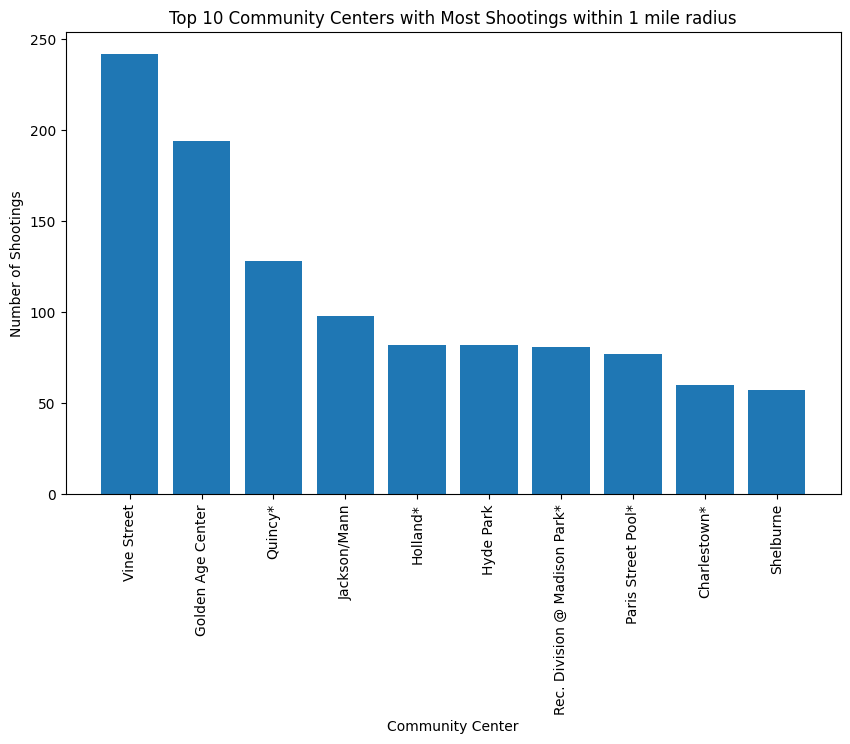

In [15]:
import matplotlib.pyplot as plt

top_centers = community_centers.sort_values(by='num_shootings_within_radius', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x = top_centers['SITE'], height=top_centers['num_shootings_within_radius'])
ax.set_title('Top 10 Community Centers with Most Shootings within 1 mile radius')
ax.set_xlabel('Community Center')
ax.set_ylabel('Number of Shootings')
plt.xticks(rotation=90)
plt.show()

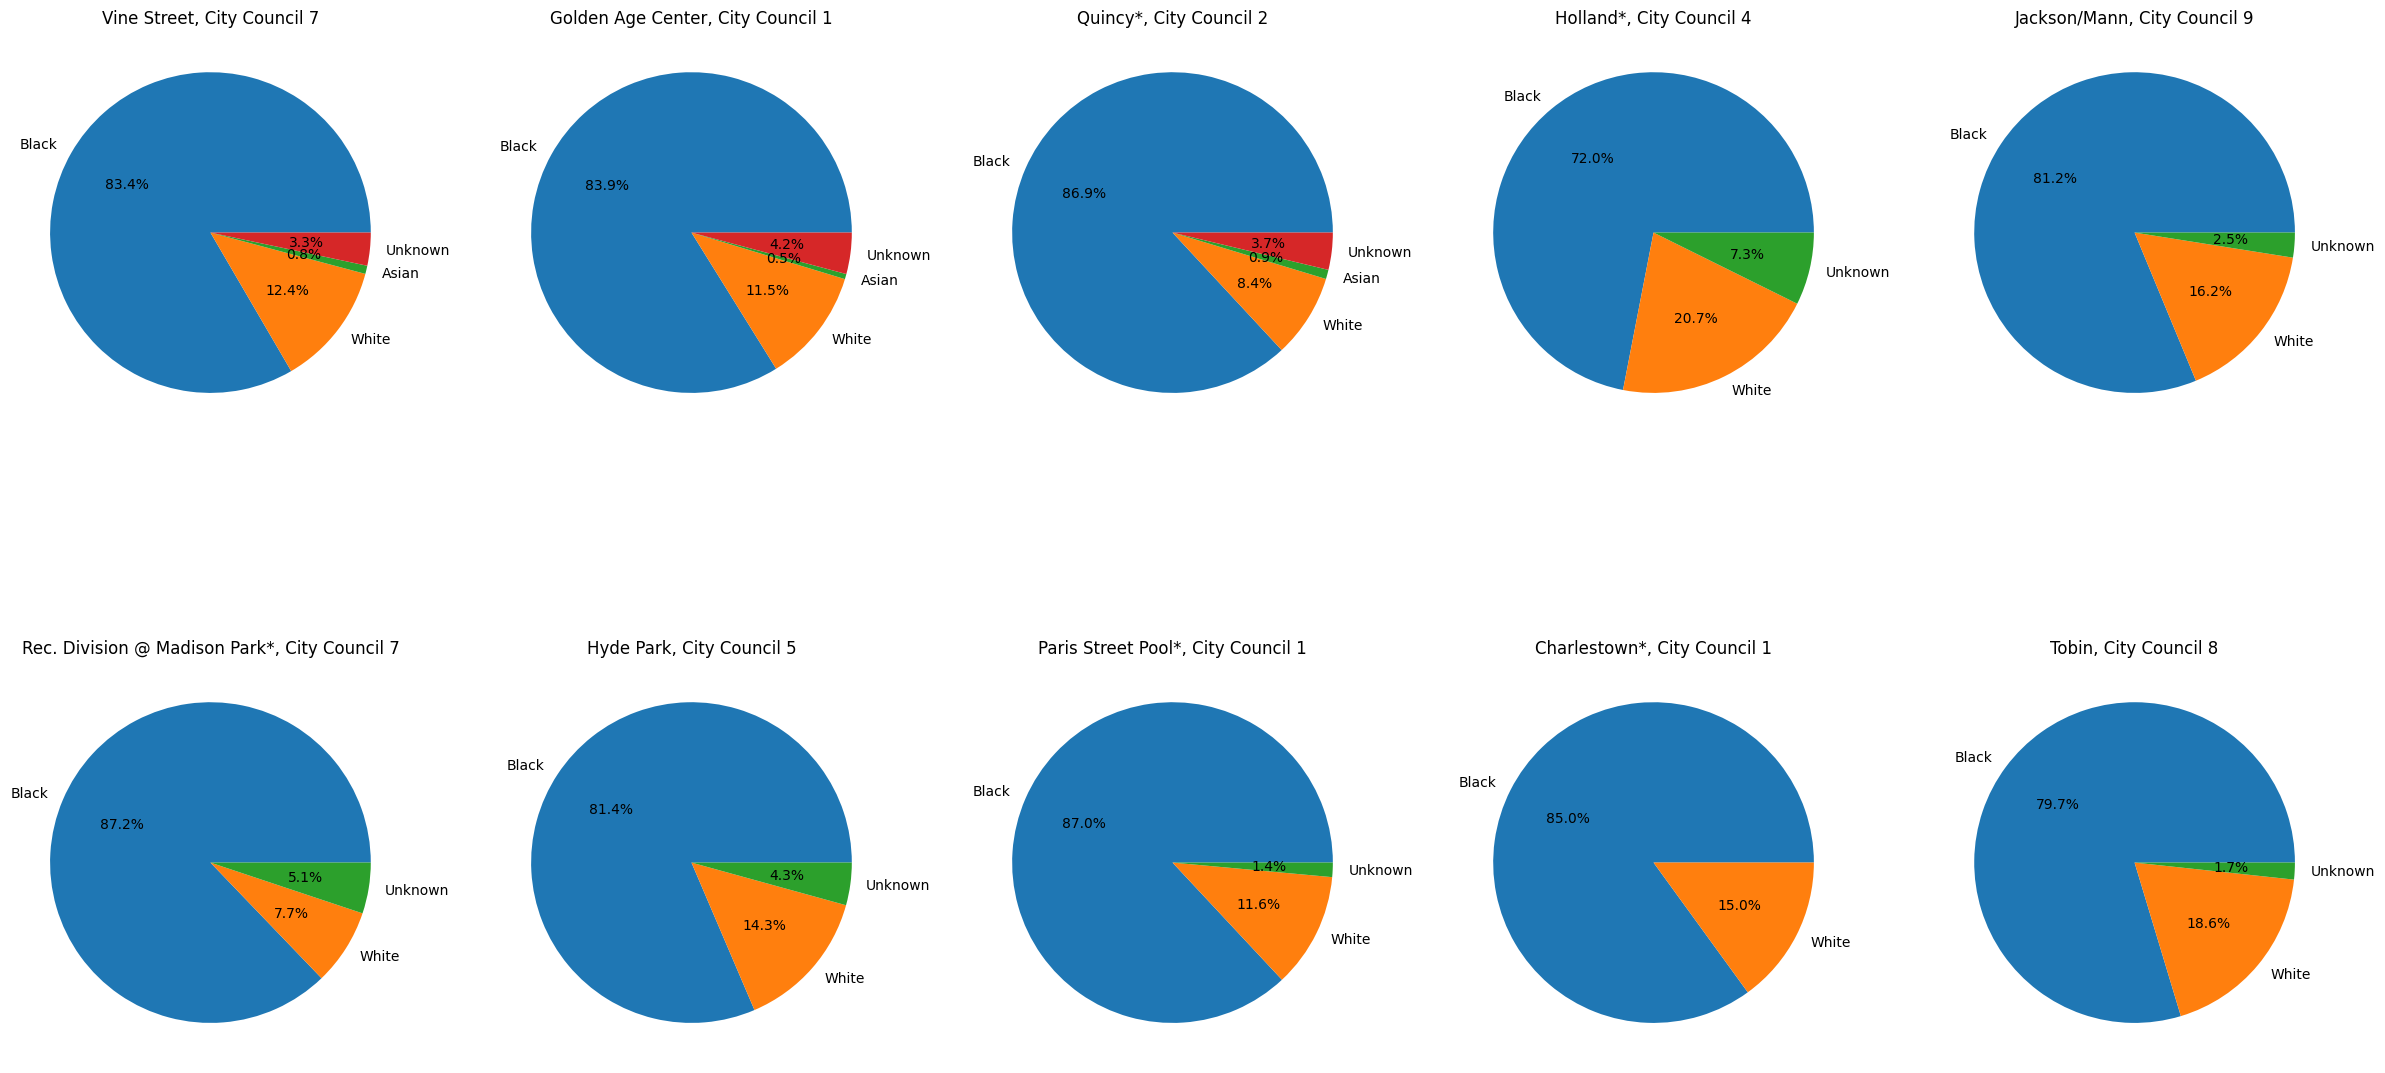

In [ ]:
labels = ['Black', 'White', 'Asian', 'Unknown']
fig, ax = plt.subplots(2, 5)
fig.set_figheight(15)
fig.set_figwidth(30)

for i in range(len(top_centers)):
    row = 0
    if i <=4:
        column = i
    else:
        column = i - 5

    if i >= 5:
        row = 1

    sizes = [top_centers.iloc[i]['num_black_victims'], top_centers.iloc[i]['num_white_victims'], top_centers.iloc[i]['num_asian_victims'], top_centers.iloc[i]['num_unknown_victims']]
    victim_labels = labels.copy()
    to_remove = False
    for j in range(len(sizes)):
        if sizes[j] == 0:
            victim_labels[j] = None
            to_remove = True
    if to_remove:
        new_victim_labels = [label for label in victim_labels if label is not None]
        sizes = [size for size in sizes if size != 0]
    else:
        new_victim_labels = victim_labels

    title = top_centers.iloc[i]['SITE'] + ", City Council " + str(top_centers.iloc[i]['city_council_id'])
    ax[row, column].pie(sizes, labels=new_victim_labels, autopct='%1.1f%%')
    ax[row, column].title.set_text(title)

plt.show()


Key Findings:

1. More shootings near Community Centers seem to happen in City Council 1 and 7, with 3 Community Centers each in the top 10 list.

2. There is only 1 Community Center from City Council 4 (Holland) in the top 10 list.

3. In every Community Center on the top 10 list, more than 75% of the victims are Black.

4. The Community Center at Holland (City Council 4) has the highest number of White and Asian victims out of the Community Centers in the top 10 list at 19.5% and 1.1 % respectively. 

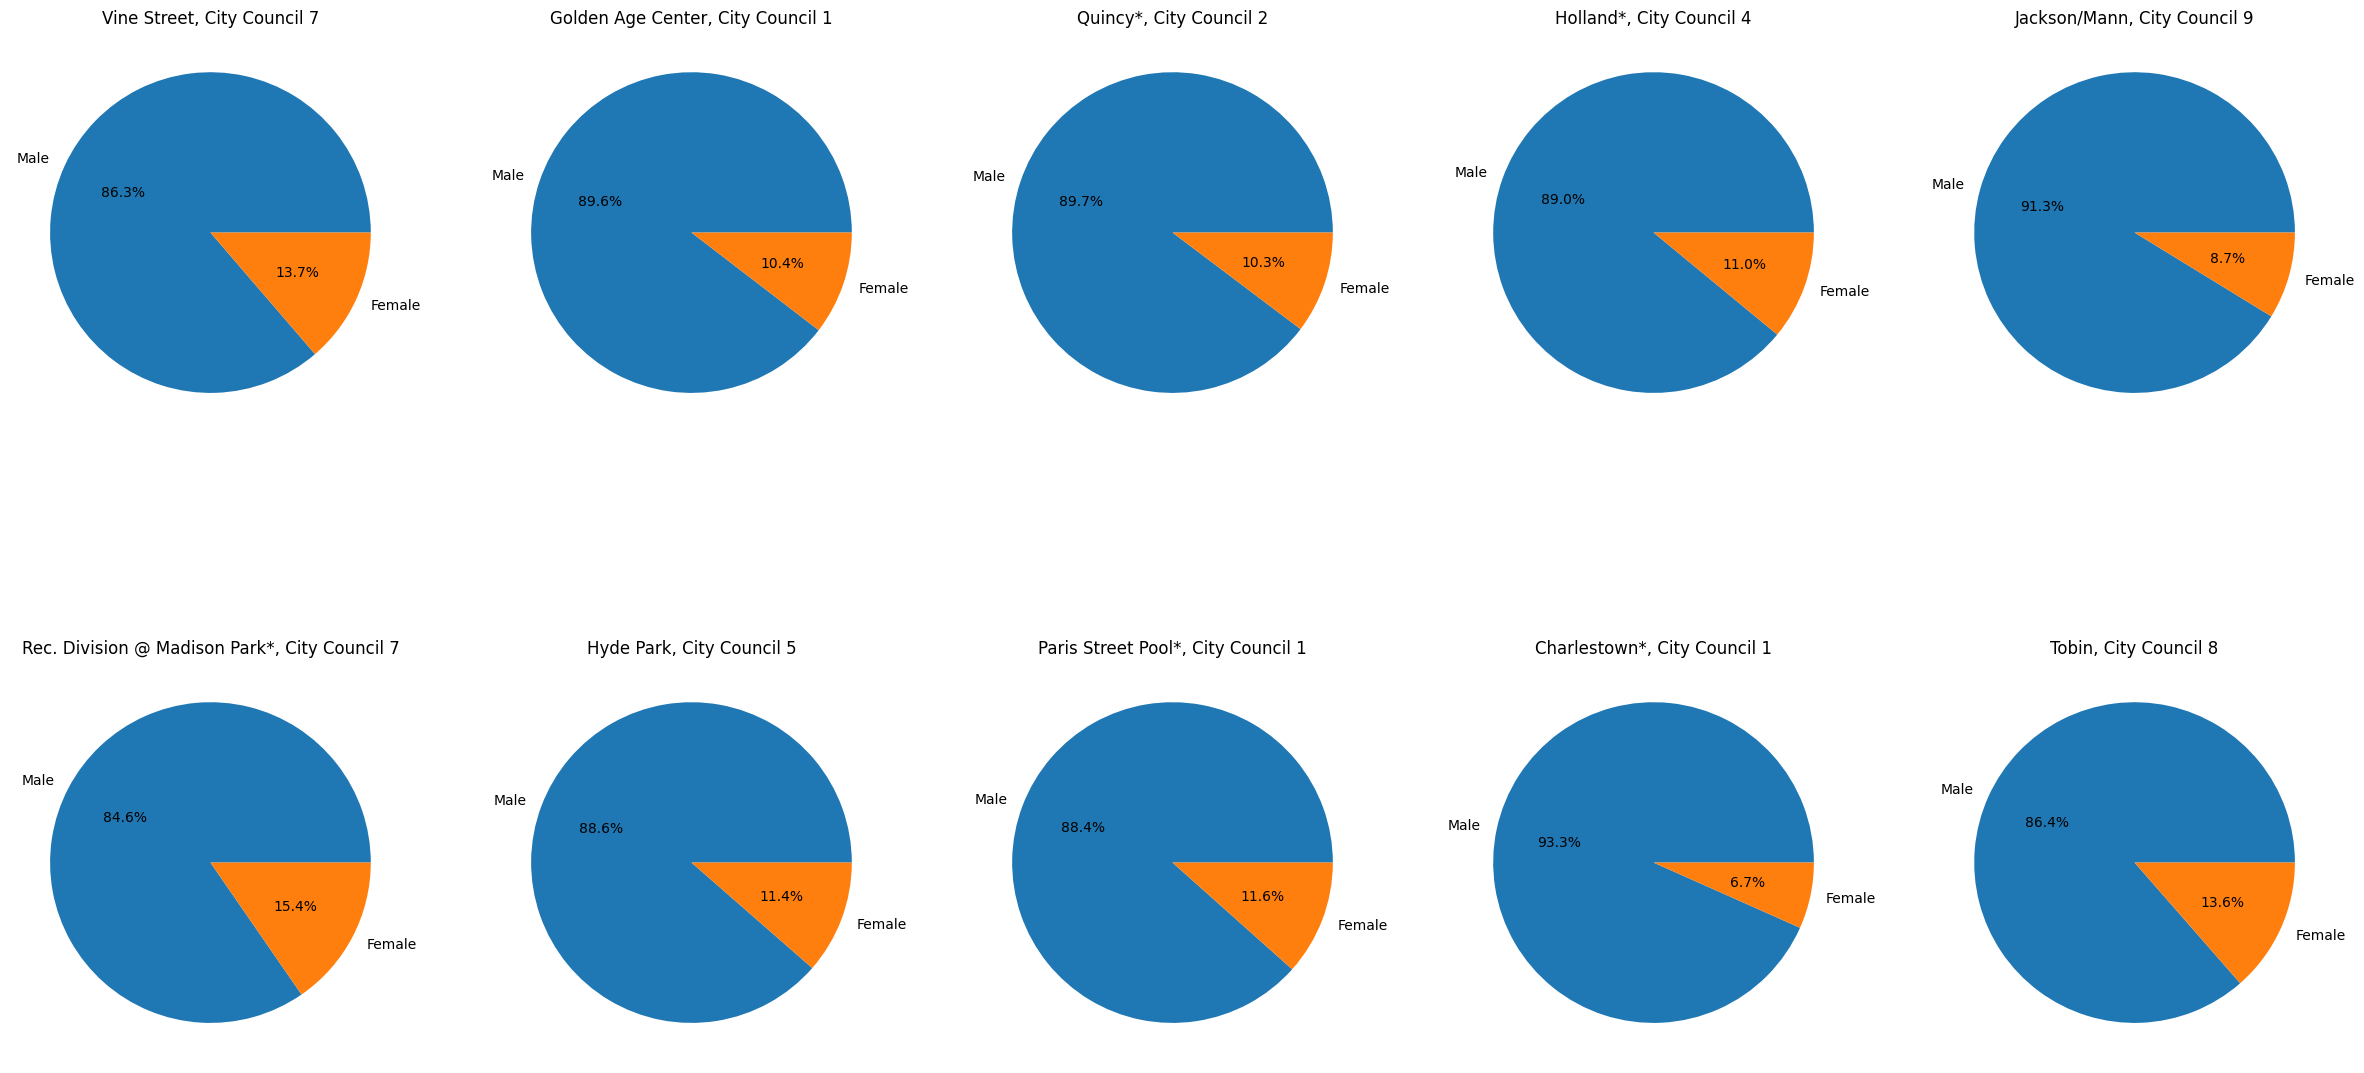

In [ ]:
labels = ['Male', 'Female']
fig, ax = plt.subplots(2, 5)
fig.set_figheight(15)
fig.set_figwidth(30)

for i in range(len(top_centers)):
  row = 0
  if i <=4:
    column = i
  else:
    column = i - 5

  if i >= 5:
    row = 1
  
  sizes = [top_centers.iloc[i]['num_male_victims'], top_centers.iloc[i]['num_female_victims']]
  victim_labels = labels.copy()
  to_remove = False
  for j in range(len(sizes)):
    if sizes[j] == 0:
      victim_labels.pop(j)
      to_remove = True
  if to_remove:
    sizes.remove(0)
  
  title = top_centers.iloc[i]['SITE'] + ", City Council " + str(top_centers.iloc[i]['city_council_id'])
  ax[row, column].pie(sizes, labels=victim_labels, autopct='%1.1f%%')
  ax[row, column].title.set_text(title)

plt.show()

Key Findings:

1. In all the Community Centers in the top 10 list, there are always more male victims than female victims (more than 80% of the victims are males in every case vs more than 8% for females).

2. Golden Age Community Center in City Council 1 has the highest percentage of male victims at 91%, whereas for females, it is at Charlestown also in City Council 1, with 17%.